Criando nosso modelo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
%matplotlib inline
plt.style.use('seaborn-darkgrid')

### Contruindo um modelo forte o suficiente mas não absurdamente complexo

----

O atual desafio é escolher funcoes boas o sucientes para representar os valores dos parametros que realmente podem mudar com o tempo

##### Parametros que realmente podem alterar com o tempo:

beta - taxa de trasmissão 

r - reducao da taxa de trasmissao

rho - taxa de testagem

p - proporcao da população praticando o afastamento social

---

In [188]:
#contruimos nosso modelo f especificando o sistema de edos
def f(xs,t,ps):
    
    # Esse try é conveniente para mais tarde passar um dicionario dos parametros para
    # poder fazer o fitting do modelo aos dados com o biblioteca lmfit
    
    #para mais detalhes dos parametros olhar o .pdf dos resultados finais
    try:
        tau = ps['tau'].value
        sigma = ps['sigma'].value
        alpha = ps['alpha'].value
        lambd1 = ps['lambd1'].value
        lambd2 =ps['lambd2'].value
        mu =ps['mu'].value
        mu2 =ps['mu2'].value
        tmu = ps['tmu'].value
        delta =ps['delta'].value
        beta =ps['beta'].value
        r =ps['r'].value
        rho = ps['rho'].value
        irho = ps['irho'].value
        p = ps['p'].value
        p2 = ps['p2'].value
        tp = ps['tp'].value
        
        #testando uma loucura aqui
        #tau1, tau2, tau3, tau4 = ps['tau1'].value, ps['tau2'].value, ps['tau3'].value, ps['tau4'].value
        #sigma1,sigma2,sigma3,sigma4 = ps['sigma1'].value,ps['sigma2'].value,ps['sigma3'].value,ps['sigma4'].value
        #alpha1,alpha2,alpha3,alpha4 = ps['alpha1'].value,ps['alpha2'].value,ps['alpha3'].value,ps['alpha4'].value
        
    except:
        
        tau, sigma, alpha, lambd1, lambd2, mu,mu2,tmu, delta, beta, r, rho, irho, p, p2, tp = ps
        
    
    #inicializando os valores dos estados do nosso sistema
    
    St, E, Eq, I, Iq, A, Aq, Q, R, D = xs
    
    #Parametros adicionais para tornar os parametros do nosso sistema variaveis
    
    #poly = lambda x, a, b, c, d, e: e+d*x+c*x**2+b*x**3+a*x**4 if e+d*x+c*x**2+b*x**3+a*x**4 > 0 else 0
    
    def poly(x, a, b, c, d, e):
        y = e+d*x+c*x**2+b*x**3+a*x**4
    
        if y > 1.5:
            return 1.5
        elif y < 0: 
            return 0
        else:
            return y 
    
    #tau = poly(t,tau4,tau3,tau2,tau1,tau)
    #sigma = poly(t,sigma4,sigma3,sigma2,sigma1,sigma)
    #alpha = poly(t,alpha4, alpha3,alpha2, alpha1,alpha)
    
    #if t > tp: p = p2

    #if t > tmu: mu = mu2
    
   # rho = t*rho + irho
    
        
        
    # Separando o numero de sucetiveis que estao praticando o distanciamento social dos que nao estao
    
    
    S = (1-p)*St
    Sq = p*St
    
    return [
        -beta*S*(I+A+r*(Iq+Aq))-r*beta*Sq*(I+A+r*(Iq+Aq)),
        beta*S*(I+A+r*(Iq+Aq))-rho*delta*E-tau*E,
        r*beta*Sq*(I+A+r*(Iq+Aq))-rho*delta*Eq-tau*Eq,
        tau*E-sigma*I-rho*I,
        tau*Eq-sigma*Iq-rho*Iq,
        alpha*sigma*I-rho*A-lambd1*A,
        alpha*sigma*Iq-rho*Aq-lambd1*Aq,
        sigma*(1-alpha)*(I+Iq)+rho*(delta*(E+Eq)+I+Iq+A+Aq)-lambd2*Q-mu*Q,
        lambd1*(A+Aq)+lambd2*Q,
        mu*Q
           ]

# funcao g ira tratar valores iniciais para que a soma deles somam 1 e devolve a solucao 
# numerica do nosso modelo dado tempo, condicoes inicais e parametros
def g(t, x0, ps):
    St = 1 - np.sum(x0)
    x0 = np.insert(x0,0,St)
    x = odeint(f,x0, t, args = (ps,))
    return x


#funcao residual é usada mais tarde pela biblioteca lmfit para fittar o modelo aos dados
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['Eq'].value,ps['I'].value,ps['Iq'].value,ps['A'].value,ps['Aq'].value,ps['Q'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    
    model = model[:,3]+model[:,4] #soma dos infectados praticando isomaneto social com os que nao estao
    model *= 8.3*10e6 #multiplicando pela populcao da cidade de NY
    
    return (model - data).ravel()

In [176]:
#intervalo de tempo que estamos rodando nosso modelo
t = np.linspace(0,70,70)

# chute das condicoes iniciais
x0 = np.array([5.4456e-05,4.8680e-05,7.2747e-07,2.9265e-06,0,0,0,0,0])

### Primeira tentativa de fittar os parametros

---

Vamos nos utilizar da biblioteca lmfit e vamos tentar primeiro fittar em cima do numero de infectados e mais tarde tentar utilizar todos os dados

---

In [21]:
from lmfit import minimize, Parameters, Parameter, report_fit

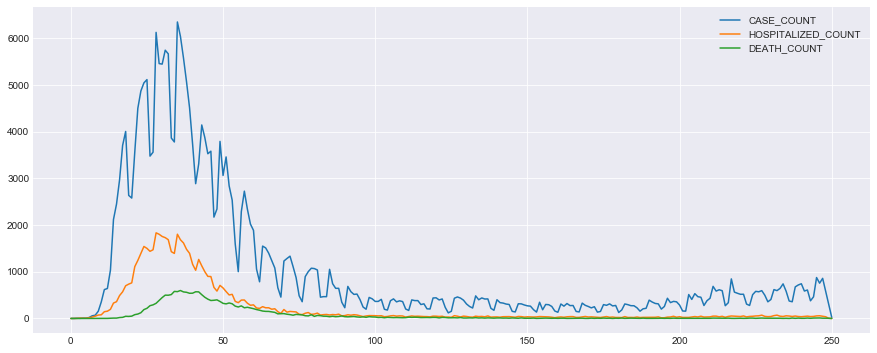

In [22]:
df = pd.read_csv("COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv")
df.plot(figsize = (15,6))
plt.show()

In [23]:
#vamos tentar fittar usando somente dados dos infectados
cases = df[['CASE_COUNT']].to_numpy()

#transformando uma lista de listas em uma lista
ny_cases = cases.ravel()

In [192]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=5.4456e-09, min=0, max=1,vary= False)
params.add('Eq', value=4.8680e-09, min=0, max=1, vary= False)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('Aq', value=0.0, min=0, max=1, vary= False)
params.add('Q', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=7.2747e-09, min=0, max=10e-4, vary= False)
params.add('Iq', value=2.9265e-09, min=0, max=1, vary= False)

#parametros do modelo
params.add('tau', value=0.16584206, min=0, max=1, vary = True)
params.add('sigma', value=0.70116841, min=0, max=1, vary =True)
params.add('alpha', value=0.46800622, min=0, max=1, vary = True)
params.add('lambd1', value=0.36639115, min=0, max=1, vary = True)
params.add('lambd2', value=0.14662076, min=0, max=1, vary = True)
params.add('mu', value=0.32584105, min=0, max=1, vary = True)
params.add('mu2', value=0.10126612, min=0, max=1, vary= False)
params.add('tmu', value=60, min=0, max=251, vary= False)
params.add('delta', value=1, min=0, max=1, vary = False)
params.add('beta', value=0.64846010, min=0, max=1, vary = True)
params.add('r', value=0.50337656, min=0, max=1, vary = True)
params.add('rho', value=1.1392e-04, min=0, max=1, vary = False)
params.add('irho', value=0.13904760, min=0, max=1, vary= True)
params.add('p', value=0.00398849, min=0, max=1, vary = True)
params.add('p2', value=0.74907787, min=0, max=1, vary= False)
params.add('tp', value=30, min=0, max=251, vary= False)


#params.add('tau1', value=1.3100e-06, min=-1, max=1)
#params.add('tau2', value=1.7874e-06, min=-1, max=1)
#params.add('tau3', value=3.2841e-08, min=-1, max=1)
#params.add('tau4', value=4.4729e-10, min=-1, max=1)
#params.add('sigma1', value=-0.00129697, min=-1, max=1)
#params.add('sigma2', value=4.3791e-05, min=-1, max=1)
#params.add('sigma3', value=7.1472e-09, min=-1, max=1)
#params.add('sigma4', value=7.1472e-09, min=-1, max=1)
#params.add('alpha1', value=2.0109e-05, min=-1, max=1)
#params.add('alpha2', value=2.9252e-06, min=-1, max=1)
#params.add('alpha3', value=7.8229e-09, min=-1, max=1)
#params.add('alpha4', value=3.1974e-14, min=-1, max=1)



result = minimize(residual, params, args = (t,ny_cases[:70]), method= 'L-BFGS-B')

In [193]:
# modelo com os novos parametros
final = ny_cases[:70] + result.residual.reshape(ny_cases[:70].shape)

Temos problemas no logo no começo, esperaria que a convexidade do modelo não fosse essa

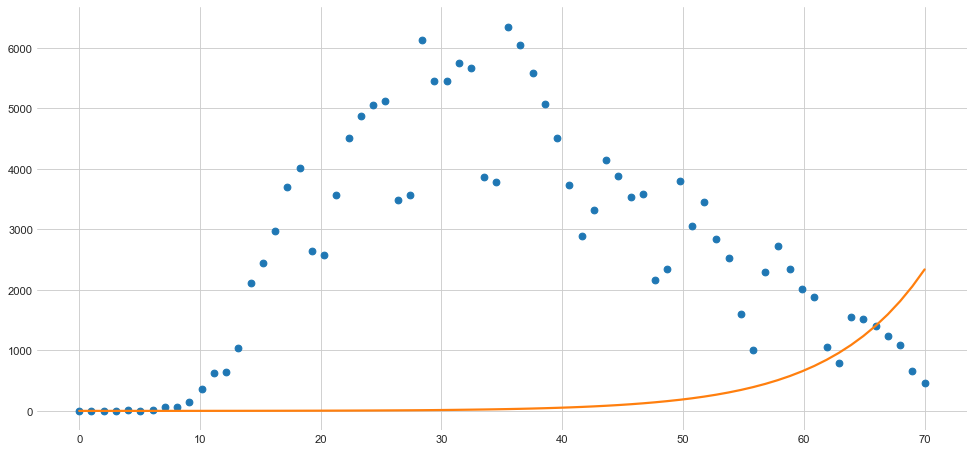

In [194]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases[:70], 'o')
plt.plot(t, final, '-', linewidth=2)
plt.show()

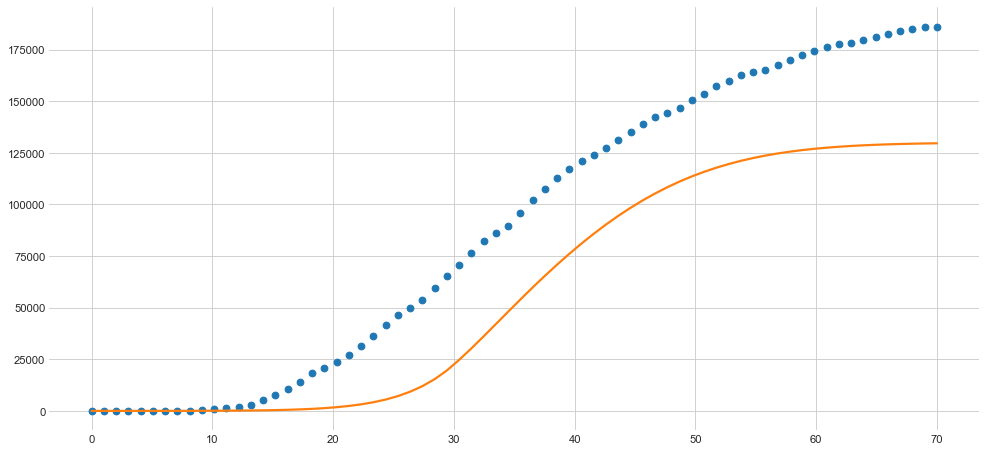

In [187]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases[:70].cumsum(), 'o')
plt.plot(t, final.cumsum(), '-', linewidth=2)
plt.show()

In [28]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 2499
    # data points      = 251
    # variables        = 16
    chi-square         = 2.2791e+08
    reduced chi-square = 969846.067
    Akaike info crit   = 3475.47533
    Bayesian info crit = 3531.88258
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       5.4456e-09 (fixed)
    Eq:      4.868e-09 (fixed)
    R:       0 (fixed)
    A:       0 (fixed)
    Aq:      0 (fixed)
    Q:       0 (fixed)
    D:       0 (fixed)
    I:       7.2747e-09 (fixed)
    Iq:      2.9265e-09 (fixed)
    tau:     0.42909047 (init = 0.1658421)
    sigma:   0.00774573 (init = 0.7011684)
    alpha:   0.41860021 (init = 0.4680062)
    lambd1:  0.36639115 (init = 0.00087054)
    lambd

### Utilizando analise de sensibilidade para melhorar o modelo

---

Vamos usar analise de sensibilidade para tentar entender melhor o motivo pelo qual nosso modelo esta com o fit deveras estranho

---


In [30]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from tqdm import tqdm
import seaborn as sns

In [50]:
#definimos aqui todos os parametros novamente junto com os possiveis valores que eles podem assumir
problema = {
    'num_vars': 16,
    
    'names': ["tau", "sigma", "alpha", "lambd1", "lambd2", "mu", "mu2", "tmu",
              "delta", "beta", "r", "rho","irho", "p","p2","tp"],
    
    'bounds': [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,251],[0,1],[0,1],
               [0,1],[0,1],[0,1],[0,1],[0,1],[0,251]]
}

In [51]:
param_values = saltelli.sample(problem, 1000)
param_values.shape

(34000, 16)

### Escolhendo de forma sensata o que analisar

---
Vamos analisar a segunda derivada do numero de infectados no começo da pandemia pra ver se conseguimos alterar parcialmente nosso modelo de forma a conseguir fittar ele de forma mais realistar

---

In [35]:
def seg_der_inf(params):
    t = np.linspace(0,20,100)
    sol = g(t,x0,params)
    Ifc = sol[:,4]+sol[:,5]
    dx = t[1]-t[0]
    dff = np.gradient(Ifc,dx)
    ddff = np.gradient(dff,dx)
    return np.mean(ddff)
    

In [36]:
tt = np.linspace(0,20,100)
sol = g(tt,x0,t_params)[:,4]
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tt, sol)
der = np.gradient(sol,tt[1]-tt[0])
plt.plot(tt,der)
dder = np.gradient(der,tt[1]-tt[0])
plt.plot(tt,dder)
plt.show()

NameError: name 't_params' is not defined

In [509]:
seg_der_inf(t_params)

1.0859864308100953e-06

In [58]:
#Simulamos de forma extremamente simples os possiveis retornos da funçao seg_der_inf
#e armazenamos elas em Y


100%|██████████| 34000/34000 [01:11<00:00, 475.86it/s]


In [59]:
Si = sobol.analyze(problem,Y, print_to_console=False)

### Interpretando os dados
---

Vamos tentar entender como deixar nosso modelo mais realista

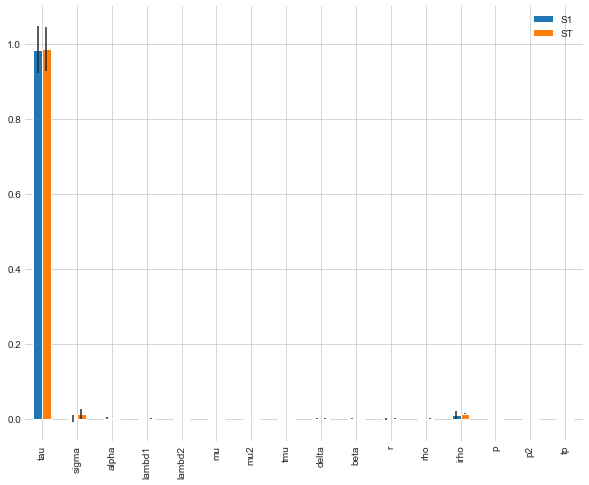

In [60]:
def plot_sobol(si,prob, order=1):
    Si_filter = {k:si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    fig, ax = plt.subplots(1, figsize=(10,8))

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    
plot_sobol(Si,problem)

-----

Acima vemos que o parametros que mais afeta a convexidade da nossa curva de infectados é:


1. Tau (inverso do periodo de latencia)

-----

Mas sempre é bom vizualizar por outros angulos paratermos uma noção melhor

In [75]:
import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names, fontsize=24)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig



class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand', fontsize=16,
              handler_map={plt.Circle: HandlerCircle()})


In [73]:
# reiniciar o kernel pra funcionar
from cirsen import *

#simplesmente estetico pra tirar a celula de cima

---

Aqui fica um pouco mais claro como os nossos parametros afetam a concavidade de nosso modelo:

1. Tau é sem duvida o principal 

2. sigma (inverso do periodo infeccioso) e irho (valor inicial da taxa de testagem) também afetam nosso modelo


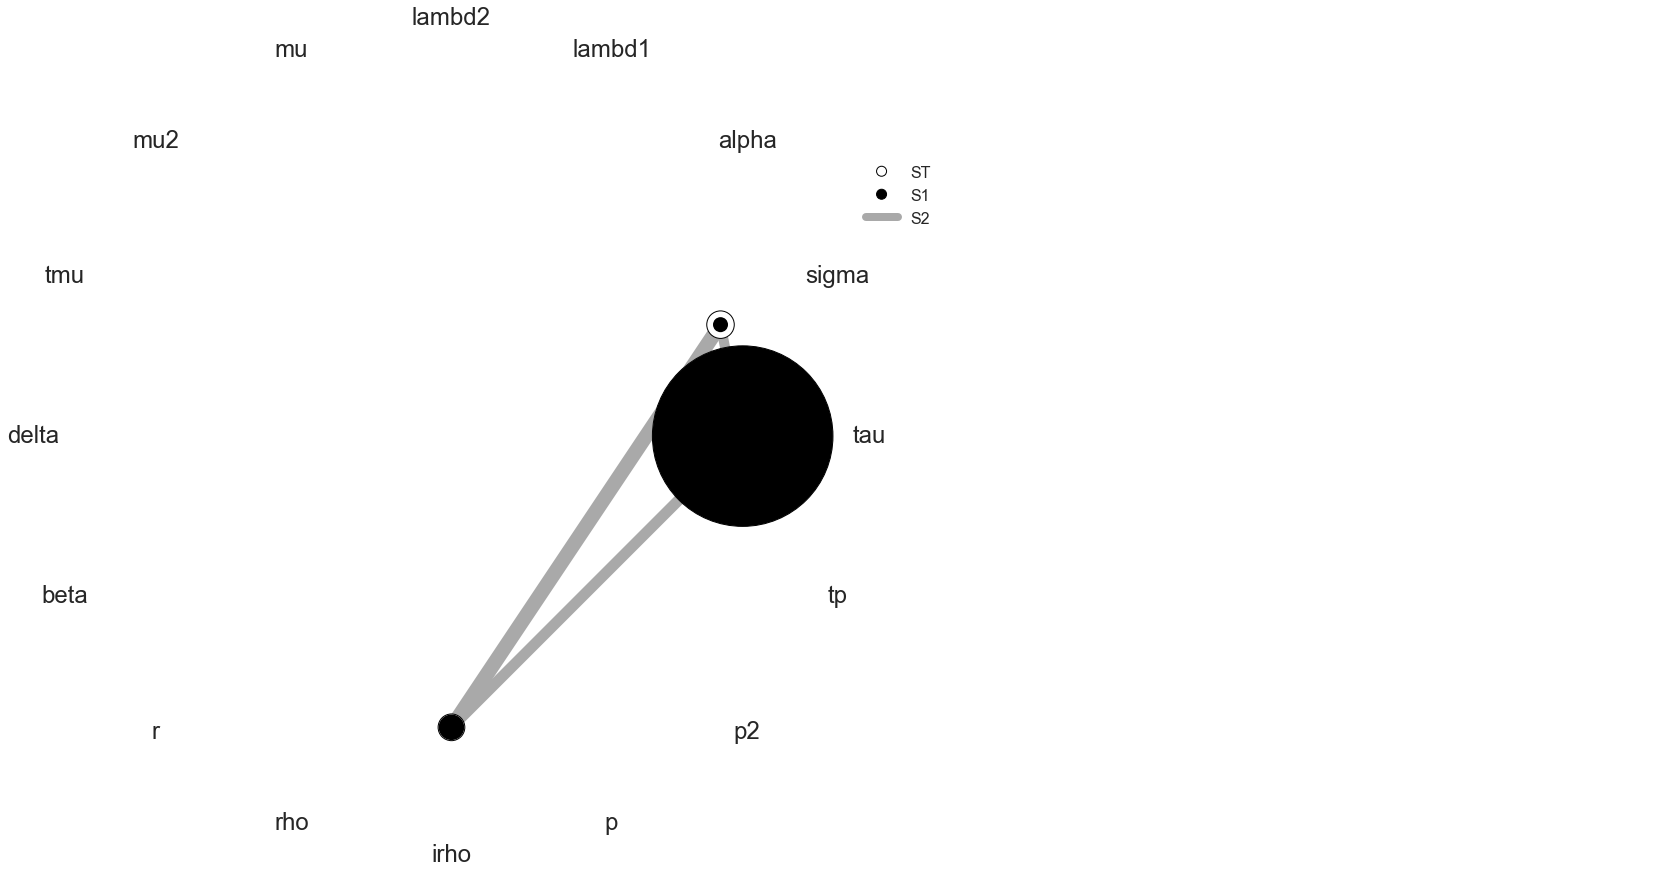

In [76]:
sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)

### Disclamer

---

Tem muita experimetacao ate tornar isso aqui algo mais serio, mas estamos aprendendo bastante assim. 

Também estou tentando colocar minha linha de raciocinio aqui para ficar facil de acompanhar

---

Quero tentar incluir na funcao **residual** uma penalidade para a convexidade da funcao, acredito que isso vai ser um cobertor curto e vamos acabar piorando o fit de algum lado, mas vale a pena tentar


In [203]:
def residual(ps, ts, data):
    x0 = ps['E'].value,ps['Eq'].value,ps['I'].value,ps['Iq'].value,ps['A'].value,ps['Aq'].value,ps['Q'].value,ps['R'].value,ps['D'].value
    model = g(ts, x0, ps)
    
    model = model[:,4]+model[:,5] #soma dos infectados praticando isomaneto social com os que nao estao
    model *= 8.3*10e6 #multiplicando pela populcao da cidade de NY
    
    
#---- usando derivada como penalização-----
    #dx = ts[1]-ts[0]
    #dff = np.gradient(model,dx)
    #penal  = dff[:20].copy()
    #penal.resize(np.shape(model))
    #if model[0] > 10:
    #    model[0] += 10000
    #model += penal
#-----------------------------------------
    
    loss = model - data
    #loss += np.array([n if i < 20 else 0 for (i,n) in enumerate(loss) ])
    
    
    
    return loss
    #return (model - data).ravel()


t = np.linspace(0,50,50)

In [204]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=5.4456e-05, min=0, max=1,vary= True)
params.add('Eq', value=4.8680e-05, min=0, max=1, vary= True)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('Aq', value=0.0, min=0, max=1, vary= False)
params.add('Q', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=7.2747e-07, min=0, max=10e-4, vary= True)
params.add('Iq', value=2.9265e-06, min=0, max=1, vary= True)

#parametros do modelo
params.add('tau', value=0.16584206, min=0, max=1)
params.add('sigma', value=0.70116841, min=0, max=1)
params.add('alpha', value=0.46800622, min=0, max=1)
params.add('lambd1', value=8.7054e-04, min=0, max=1)
params.add('lambd2', value=0.14662076, min=0, max=1)
params.add('mu', value=0.32584105, min=0, max=1)
params.add('mu2', value=0.10126612, min=0, max=1)
params.add('tmu', value=60, min=0, max=251)
params.add('delta', value=1, min=0, max=1)
params.add('beta', value=0.64846010, min=0, max=1)
params.add('r', value=0.50337656, min=0, max=1)
params.add('rho', value=1.1392e-04, min=0, max=1)
params.add('irho', value=0.13904760, min=0, max=1)
params.add('p', value=0.00398849, min=0, max=1)
params.add('p2', value=0.74907787, min=0, max=1)
params.add('tp', value=34.7148268, min=0, max=251)


result = minimize(residual, params, args = (t,m_casos[:50]), method= 'L-BFGS-B')

#comeco da pandemia
#result = minimize(residual, params, args = (t,ny_cases[:50]), method= 'leastsq')

#toda
#result = minimize(residual, params, args = (t,ny_cases), method= 'leastsq')

In [205]:
final = m_casos[:50] + result.residual.reshape(ny_cases[:50].shape)

In [206]:
m_casos = df['CASE_COUNT'].rolling(7).mean()
m_casos = m_casos.dropna().to_numpy()

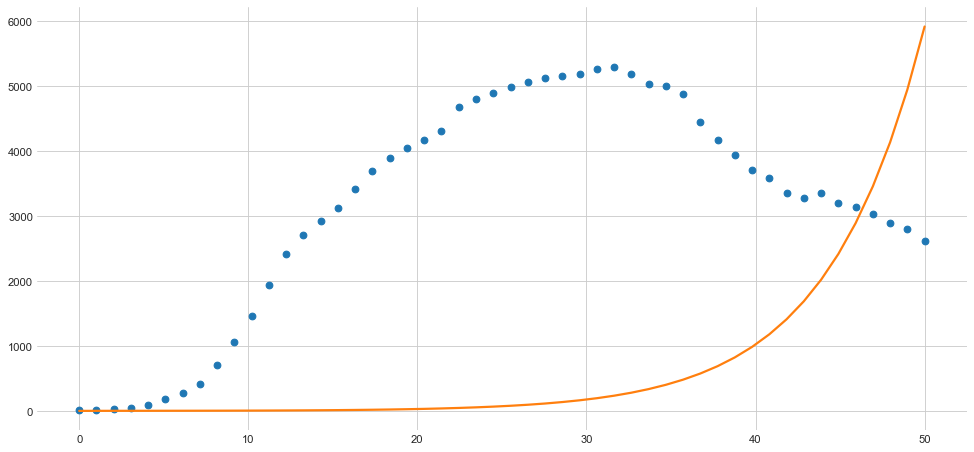

In [207]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, m_casos[:50], 'o')
plt.plot(t, final, '-', linewidth=2)
plt.show()

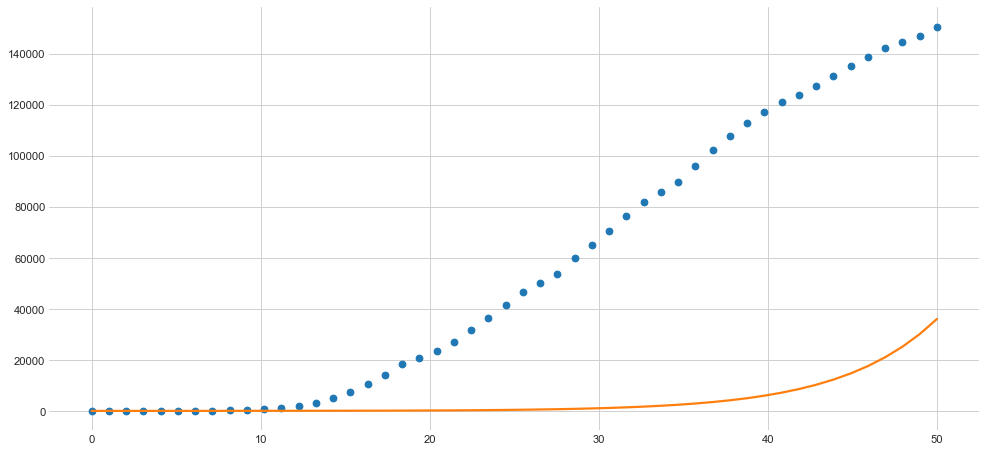

In [201]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases[:50].cumsum(), 'o')
plt.plot(t, final.cumsum(), '-', linewidth=2)
plt.show()

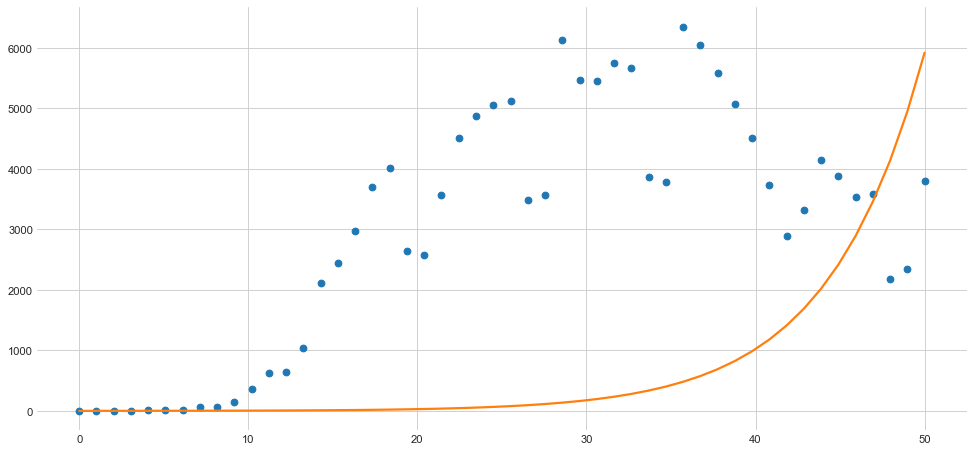

In [202]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases[:50], 'o')
plt.plot(t[:50], final, '-', linewidth=2)
plt.show()

In [112]:
result.params.get("E")

<Parameter 'E', value=7.720956339962726e-05, bounds=[0:1]>

In [113]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 1323
    # data points      = 50
    # variables        = 20
    chi-square         = 64609848.1
    reduced chi-square = 2153661.60
    Akaike info crit   = 743.592720
    Bayesian info crit = 781.833180
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       7.7210e-05 (init = 5.4456e-05)
    Eq:      6.0382e-05 (init = 4.868e-05)
    R:       0 (fixed)
    A:       0 (fixed)
    Aq:      0 (fixed)
    Q:       0 (fixed)
    D:       0 (fixed)
    I:       7.2955e-07 (init = 7.2747e-07)
    Iq:      8.7183e-06 (init = 2.9265e-06)
    tau:     0.16594541 (init = 0.1658421)
    sigma:   0.70115860 (init = 0.7011684)
    alpha:   0.46812706 (init = 0.4680062)
    la

In [114]:
t = np.linspace(0,251,251)
x0 = np.array([5.4686e-05,5.2113e-05,7.3748e-07,4.0479e-06,0,0,0,0,0])      
tau =0.17659510
sigma = 0.72416760
alpha =0.47120590 
lambd1 =1.1118e-05
lambd2 =0.14786243
mu =0.32673757
mu2=0.19248101
tmu =60
delta =0.99747301
beta =0.65151146
r = 0.50984221
rho = 1.2032e-04
irho = 0.13845088
p=0.00434997
p2=0.74560265
tp=34.7148268
t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho,irho, p, p2, tp))

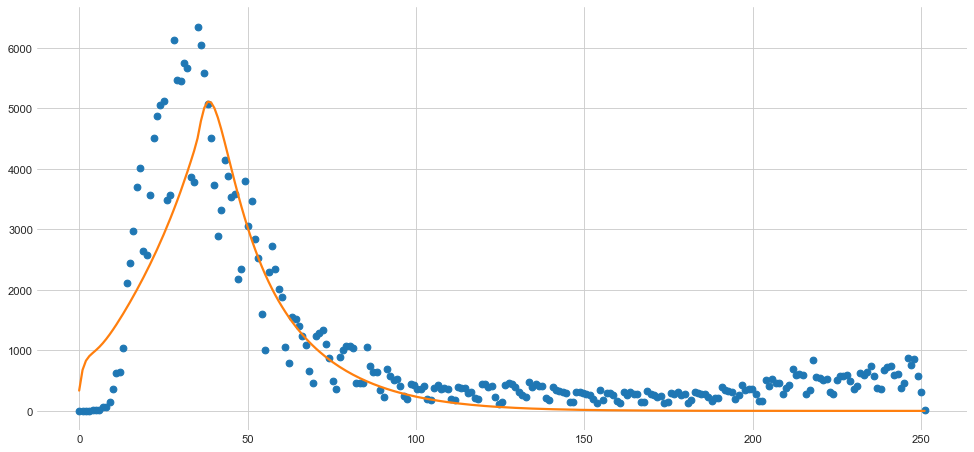

In [115]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases, 'o')
sol = g(t,x0, t_params)
Inf = sol[:,4]+sol[:,5]
plt.plot(t, 8.3*10e6*Inf, '-', linewidth=2)

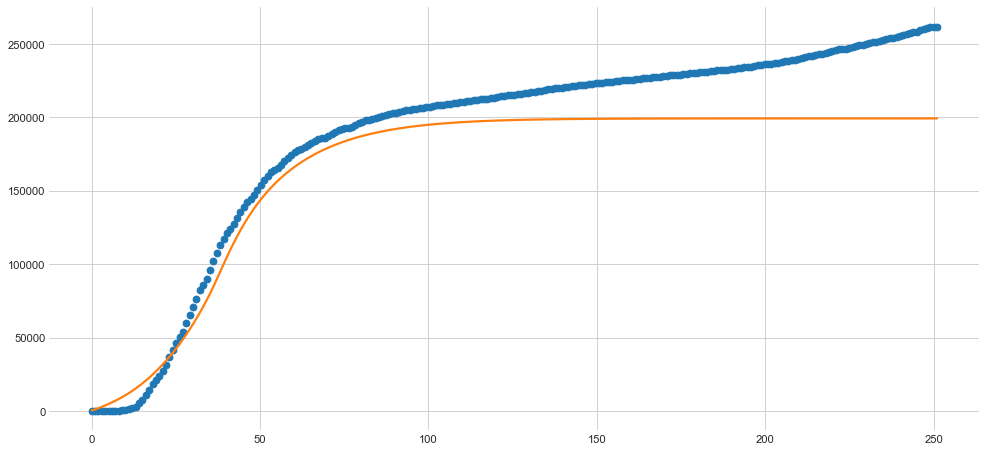

In [117]:
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases.cumsum(), 'o')
sol = g(t,x0, t_params)
Inf = sol[:,4]+sol[:,5]
plt.plot(t, 8.3*10e6*Inf.cumsum(), '-', linewidth=2)

In [465]:
#intervalo de tempo que estamos rodando nosso modelo
t = np.linspace(0,200,1000)

# chute das condicoes iniciais
x0 = np.array([10e-6,0,0,0,0,0,0,0,0])

#chute dos paramtros inicai
tau = 0.16584270
sigma = 0.70117413
alpha =  0.55
lambd1 = 1/8
lambd2 = 1/16
mu = 0.05
mu2 = 0.01
tmu = 60
delta = 1
beta = 10
r = 0.5
rho = 0.05
p = 0.5
p2 = 0.8
tp = 30

t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho, p, p2, tp))

In [461]:
g1 = g(t,x0,t_params)

plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t,g1[:,4]+g1[:,5])
plt.plot(t,g1[:,4])
plt.plot(t,g1[:,5])
plt.show()

ValueError: not enough values to unpack (expected 16, got 15)

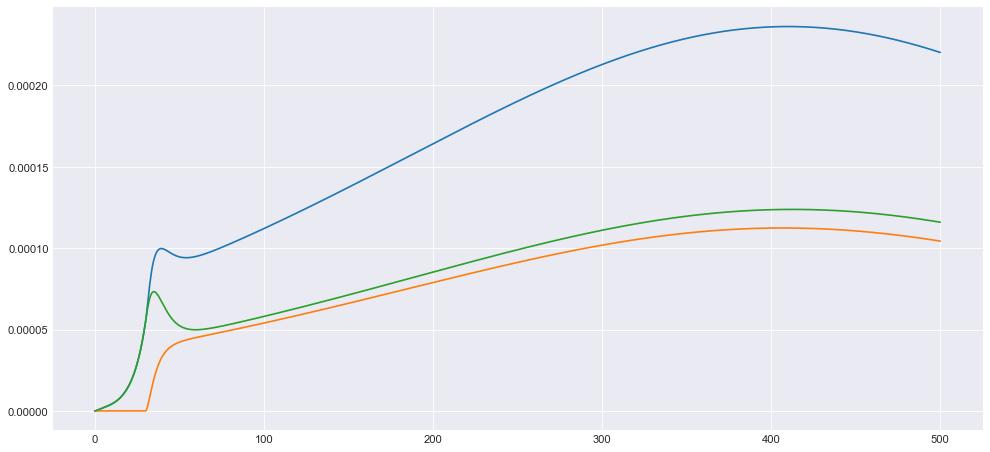

In [81]:
g1 = g(t,x0,t_params)

plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t,g1[:,4]+g1[:,5])
plt.plot(t,g1[:,4])
plt.plot(t,g1[:,5])
plt.show()

In [721]:
x0 = np.array([5.4701e-05,4.9056e-05,7.1549e-07,3.1806e-06,0,0,0,0,0])      
tau =0.47359266
sigma =0.70490680
alpha =0.47409473 
lambd1 =4.1676e-04
lambd2 =0.14683372
mu =0.32551827
mu2=0.11503023
tmu =60
delta =0.99125075
beta =0.65707114
r = 0.50984221
rho = 1.2032e-04
irho = 0.13845088
p=3.4824e-05
p2=0.74560265
tp=34.7148268
t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho,irho, p, p2, tp))

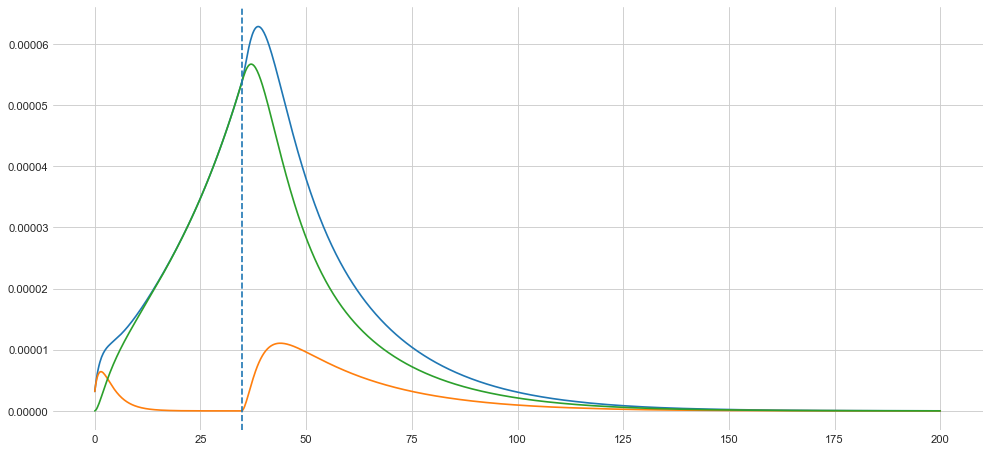

In [526]:
g1 = g(t,x0,t_params)

plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t,g1[:,4]+g1[:,5])
plt.plot(t,g1[:,4])
plt.plot(t,g1[:,5])
plt.axvline(x=tp,linestyle='--')
plt.show()

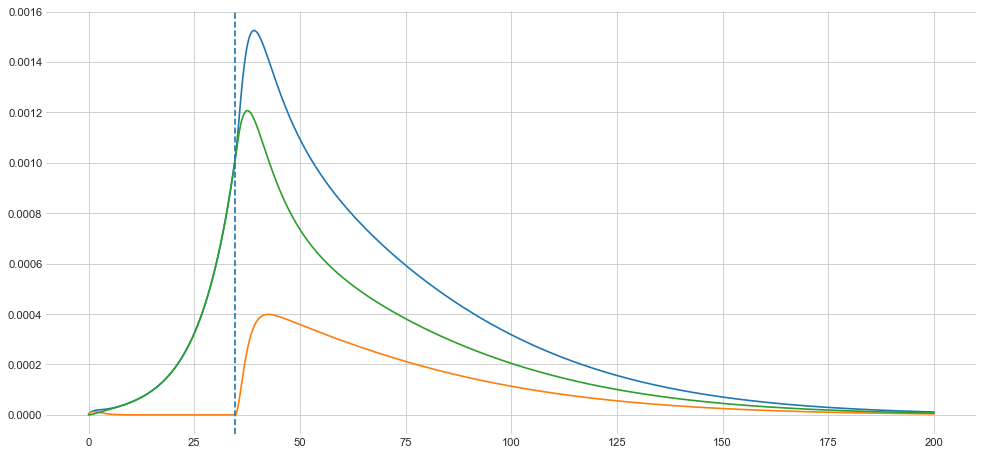

In [533]:
g1 = g(t,x0,t_params)

plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t,g1[:,4]+g1[:,5])
plt.plot(t,g1[:,4])
plt.plot(t,g1[:,5])
plt.axvline(x=tp,linestyle='--')
plt.show()

In [209]:
def poly(x, a, b, c, d, e):
        y = e+d*x+c*x**2+b*x**3+a*x**4
    
        if y > 1:
            return 1
        elif y < 0: 
            return 0
        else:
            return y 

def f(xs,t,ps):
    
    try:
        tau = ps['tau'].value
        sigma = ps['sigma'].value
        alpha = ps['alpha'].value
        lambd1 = ps['lambd1'].value
        lambd2 =ps['lambd2'].value
        mu =ps['mu'].value
        mu2 =ps['mu2'].value
        tmu = ps['tmu'].value
        delta =ps['delta'].value
        beta =ps['beta'].value
        r =ps['r'].value
        rho = ps['rho'].value
        irho = ps['irho'].value
        p = ps['p'].value
        p1 = ps['p1'].value
        p2 = ps['p2'].value
        p3 = ps['p3'].value
        p4 = ps['p4'].value
        
    except:
        
        tau, sigma, alpha, lambd1, lambd2, mu,mu2,tmu, delta, beta, r, rho, irho, p,p1,p2,p3,p4 = ps
  

    St, E, Eq, I, Iq, A, Aq, Q, R, D = xs
   
    def poly(x, a, b, c, d, e):
        y = e+d*x+c*x**2+b*x**3+a*x**4
    
        if y > 1:
            return 1
        elif y < 0: 
            return 0
        else:
            return y 
    
    #tau = poly(t,tau4,tau3,tau2,tau1,tau)
    #sigma = poly(t,sigma4,sigma3,sigma2,sigma1,sigma)
    p = poly(t,p4,p3,p2,p1,p)

    rho = t*rho + irho 
    
    S = (1-p)*St
    Sq = p*St
    
    return [
        -beta*S*(I+A+r*(Iq+Aq))-r*beta*Sq*(I+A+r*(Iq+Aq)),
        beta*S*(I+A+r*(Iq+Aq))-rho*delta*E-tau*E,
        r*beta*Sq*(I+A+r*(Iq+Aq))-rho*delta*Eq-tau*Eq,
        tau*E-sigma*I-rho*I,
        tau*Eq-sigma*Iq-rho*Iq,
        alpha*sigma*I-rho*A-lambd1*A,
        alpha*sigma*Iq-rho*Aq-lambd1*Aq,
        sigma*(1-alpha)*(I+Iq)+rho*(delta*(E+Eq)+I+Iq+A+Aq)-lambd2*Q-mu*Q,
        lambd1*(A+Aq)+lambd2*Q,
        mu*Q
           ]

In [220]:
params = Parameters()

#adicionando todos parametros necessarios para rodar o modelo

#tratamos as condiçoes inicias como parametros tb
params.add('E', value=5.4456e-05, min=0, max=1,vary= True)
params.add('Eq', value=4.8680e-05, min=0, max=1, vary= True)
params.add('R', value=0.0, min=0, max=1, vary= False)
params.add('A', value=0.0, min=0, max=1, vary= False)
params.add('Aq', value=0.0, min=0, max=1, vary= False)
params.add('Q', value=0.0, min=0, max=1, vary= False)
params.add('D', value=0.0, min=0, max=1, vary= False)
params.add('I', value=7.2747e-07, min=0, max=10e-4, vary= True)
params.add('Iq', value=2.9265e-06, min=0, max=1, vary= True)

#parametros do modelo
params.add('tau', value=0.16584206, min=0, max=1)
params.add('sigma', value=0.70116841, min=0, max=1)
params.add('alpha', value=0.46800622, min=0, max=1)
params.add('lambd1', value=8.7054e-04, min=0, max=1)
params.add('lambd2', value=0.14662076, min=0, max=1)
params.add('mu', value=0.32584105, min=0, max=1)
params.add('mu2', value=0.10126612, min=0, max=1)
params.add('tmu', value=60, min=0, max=251)
params.add('delta', value=1, min=0, max=1)
params.add('beta', value=0.64846010, min=0, max=1)
params.add('r', value=0.50337656, min=0, max=1)
params.add('rho', value=1.1392e-04, min=0, max=1)
params.add('irho', value=0.13904760, min=0, max=1)
params.add('p', value=1, min=0, max=1, vary = True)
params.add('p1', value=0, min=-10, max=10,vary= True )
params.add('p2', value=0, min=-10, max=10, vary= True)
params.add('p3', value=0, min=-10, max=10, vary= True)
params.add('p4', value=0, min=-10, max=10, vary= True)




#params.add('tau1', value=1.3100e-06, min=-1, max=1)
#params.add('tau2', value=1.7874e-06, min=-1, max=1)
#params.add('tau3', value=3.2841e-08, min=-1, max=1)
#params.add('tau4', value=4.4729e-10, min=-1, max=1)
#params.add('sigma1', value=-0.00129697, min=-1, max=1)
#params.add('sigma2', value=4.3791e-05, min=-1, max=1)
#params.add('sigma3', value=7.1472e-09, min=-1, max=1)
#params.add('sigma4', value=7.1472e-09, min=-1, max=1)
#params.add('alpha1', value=2.0109e-05, min=-1, max=1)
#params.add('alpha2', value=2.9252e-06, min=-1, max=1)
#params.add('alpha3', value=7.8229e-09, min=-1, max=1)
#params.add('alpha4', value=3.1974e-14, min=-1, max=1)



result = minimize(residual, params, args = (np.linspace(0,251,251),ny_cases), method= 'bfgs')

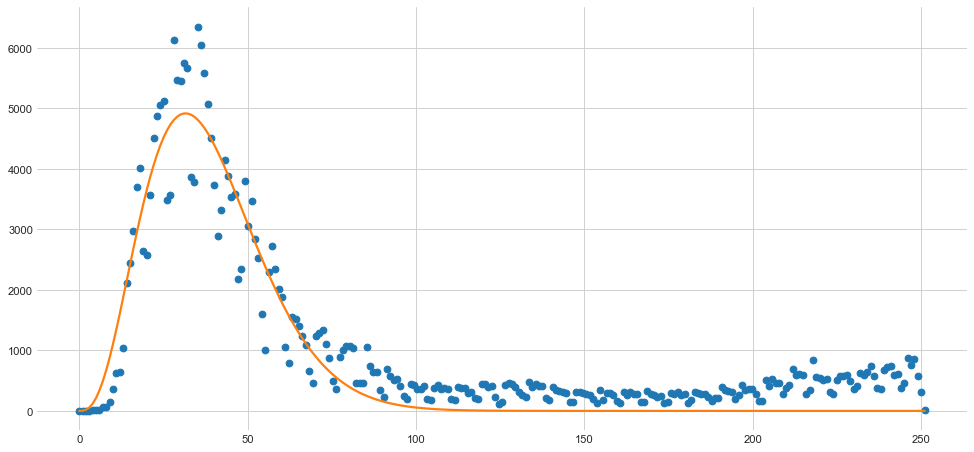

In [222]:
# modelo com os novos parametros
final = ny_cases + result.residual.reshape(ny_cases.shape)
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.linspace(0,251,251), ny_cases, 'o')
plt.plot(np.linspace(0,251,251), final, '-', linewidth=2)
plt.show()

In [ ]:
# modelo com os novos parametros
final = ny_cases + result.residual.reshape(ny_cases.shape)
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, ny_cases, 'o')
plt.plot(t, final, '-', linewidth=2)
plt.show()

In [1099]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = BFGS
    # function evals   = 3323
    # data points      = 251
    # variables        = 22
    chi-square         = 1.0232e+08
    reduced chi-square = 446798.759
    Akaike info crit   = 3286.45129
    Bayesian info crit = 3364.01126
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    E:       0.00633469 (init = 5.4456e-05)
    Eq:      1.9634e-04 (init = 4.868e-05)
    R:       0 (fixed)
    A:       0 (fixed)
    Aq:      0 (fixed)
    Q:       0 (fixed)
    D:       0 (fixed)
    I:       1.7124e-08 (init = 7.2747e-07)
    Iq:      4.2209e-08 (init = 2.9265e-06)
    tau:     4.6042e-04 (init = 0.1658421)
    sigma:   0.00225006 (init = 0.7011684)
    alpha:   0.73973184 (init = 0.4680062)
    lambd

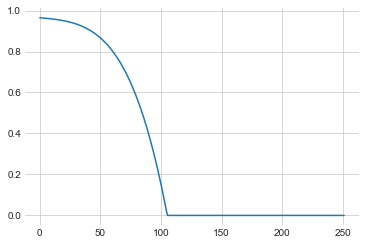

In [1006]:
plt.plot(t,[poly(i,-4.8345e-09,-2.1120e-07,-7.1624e-06,-4.7891e-04,0.96478188) for i in t ])

In [839]:
t = np.linspace(0,100,200)
t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho, irho, p, p2, tp, 1))
sol = g(t,x0,t_params)

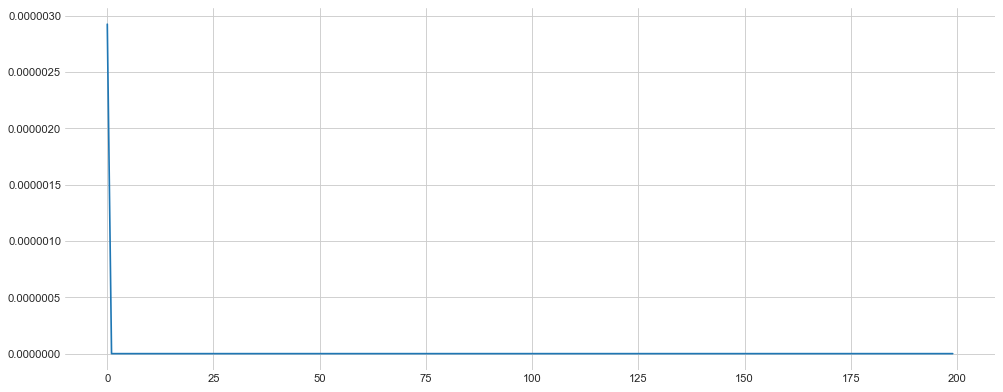

In [838]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(sol[:,4])
plt.show()

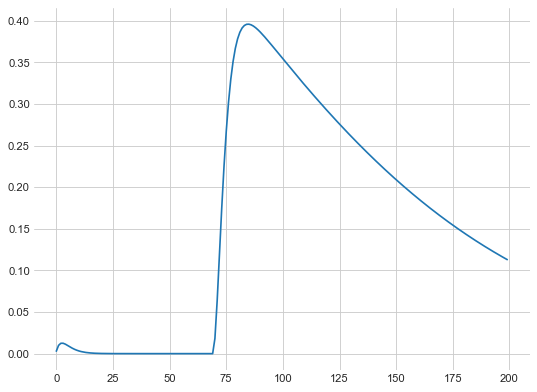

In [840]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(1000*sol[:,4])

In [1063]:
t = np.linspace(0,251,251)
x0 = np.array([10e-6,0,0,0,0,0,0,0,0])

tau = 1/3
sigma = 0.5
alpha = 0.6
lambd1 = 1/8
lambd2 = 1/16
mu = 0.05
mu2 = 0.01
tmu = 60
delta = 1
beta = 0.8
r = 1
rho = 0.0001
irho = 0.05
p = 0
p2 = 0.9
tp = 50


t_params = np.array((tau, sigma, alpha, lambd1, lambd2, mu, mu2, tmu, delta, beta, r, rho, irho, p, p2, tp))

In [1064]:
sol = g(t,x0,t_params)

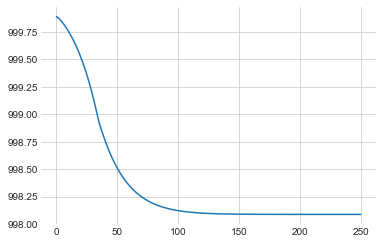

In [149]:
plt.plot(1000*sol[:,0])

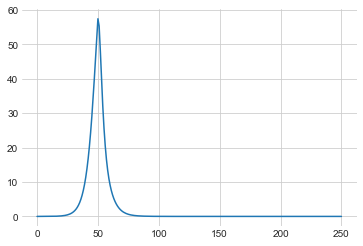

In [1066]:
plt.plot(1000*sol[:,3])

In [124]:
sol[:,[]]

IndexError: index 18 is out of bounds for axis 1 with size 10

In [125]:
sh = lambda x: [x[0]+x[1], x[2]]

[1.2890823832736286e-05, 2.54551653402895e-06]

In [148]:
0*np.array(list(map(lambda x: [x[0]+x[1], x[2]],sol[:,[3,4,9]])))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

AttributeError: module 'numpy' has no attribute 'to_array'